# Определение стоимости автомобилей

Сервис по продаже подержанных автомобилей разрабатывает приложение для привлечения новых клиентов. С помощью приложения можно узнать рыночную стоимость своего автомобиля. Нам предоставлены исторические данные об автомобилях: технические характеристики, комплектации и цены.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [31]:
#импортируем нужные библиотеки
import pandas as pd
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import time 

#давим варнинги
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [32]:
#открываем и изучаем данные
df = pd.read_csv('/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [33]:
display(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [34]:
#проверяем на пропуски
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [35]:
#проверяем на дубликаты
df.duplicated().sum()

#удаляем дубликаты
df = df.drop_duplicates().reset_index(drop=True)

4

**Исследование признаков**

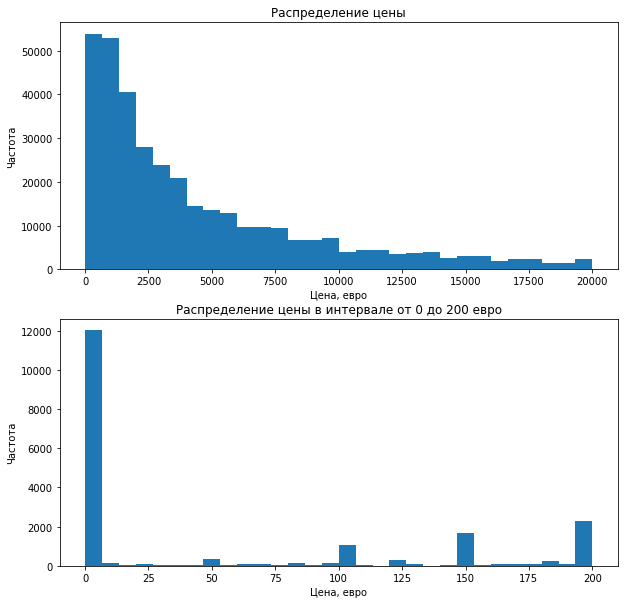

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [37]:
#строим распределение 
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.hist(df['Price'], bins=30,range=(0,20000))
plt.title('Распределение цены')
plt.xlabel('Цена, евро')
plt.ylabel('Частота')

plt.subplot(212)
plt.hist(df['Price'], bins=30,range=(0,200))
plt.title('Распределение цены в интервале от 0 до 200 евро')
plt.xlabel('Цена, евро')
plt.ylabel('Частота')
plt.show()
df['Price'].describe()

В распределении цены присутствуют большое число значений в районе 0 (более 3%). Эти значения не правдоподобны и могут снизить эффективность предсказаний, поэтому отфильтровываем их.

In [38]:
#удаляем выбросы
df_clear = df.query('Price > 1')

In [39]:
df_clear.shape[0] / df.shape[0]

0.9662466665726017

In [40]:
df['VehicleType'].value_counts(normalize=True)

sedan          0.288622
small          0.251929
wagon          0.205649
bus            0.090809
convertible    0.063757
coupe          0.051001
suv            0.037857
other          0.010376
Name: VehicleType, dtype: float64

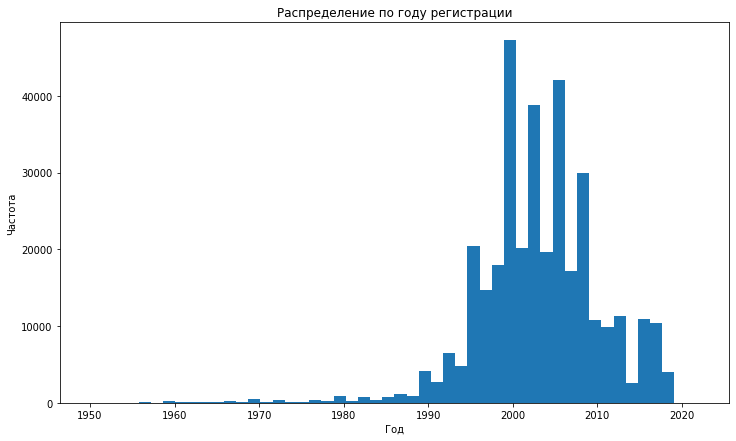

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [41]:
plt.figure(figsize=(12, 7))
plt.hist(df['RegistrationYear'],bins=50, range=(1950,2022))
plt.title('Распределение по году регистрации')
plt.xlabel('Год')
plt.ylabel('Частота')
plt.show()
df['RegistrationYear'].describe()

In [42]:
df['DateCrawled'].max()

'2016-04-07 14:36:58'

In [43]:
x = df_clear.query('1950 < RegistrationYear <= 2016')
print(x.shape[0] / df_clear.shape[0])
df_clear = x

0.9594338851181645


В данных по годам регистрации присутствуют аномальные значения, отфильтровываем их. Исходя из анкет, данные получены не позднее 2016 года, значит значения позднее 2016 ошибочны, - фильтруем их. 

In [44]:
df['Gearbox'].value_counts(normalize=True)

manual    0.801863
auto      0.198137
Name: Gearbox, dtype: float64

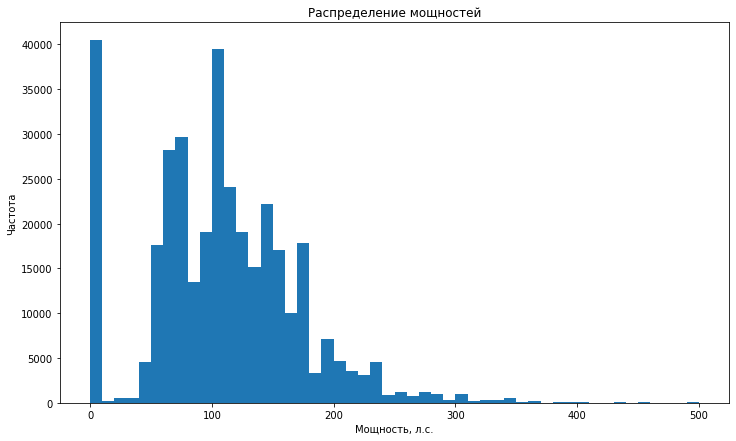

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [45]:
plt.figure(figsize=(12, 7))
plt.hist(df['Power'], bins=50, range=(0,500))
plt.title('Распределение мощностей')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Частота')
plt.show()
df['Power'].describe()

Значения ниже 10 л.с. кажутся подозрительными. Значения выше 400 практически не встречаются, но могут исказить оценку. Однако мы не можем их отфильтровать, т.к. таких значений более 10%. Вероятно, нулевые значения означают отсутствие информации о мощности авто. Т.к. у одинаковых моделей авто примерно одна мощность, целесообразно заменить аномальные значения медианой по модели.

In [46]:
x = df_clear.query('10 < Power < 400').shape[0]
print(x / df_clear.shape[0])

0.8988170975970583


In [47]:
df_clear.loc[(df_clear['Power'] < 10)|(df_clear['Power'] > 400) , 'Power'] = np.nan
df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328514 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        328514 non-null  object 
 1   Price              328514 non-null  int64  
 2   VehicleType        309009 non-null  object 
 3   RegistrationYear   328514 non-null  int64  
 4   Gearbox            313313 non-null  object 
 5   Power              295331 non-null  float64
 6   Model              313166 non-null  object 
 7   Kilometer          328514 non-null  int64  
 8   RegistrationMonth  328514 non-null  int64  
 9   FuelType           304798 non-null  object 
 10  Brand              328514 non-null  object 
 11  NotRepaired        269302 non-null  object 
 12  DateCreated        328514 non-null  object 
 13  NumberOfPictures   328514 non-null  int64  
 14  PostalCode         328514 non-null  int64  
 15  LastSeen           328514 non-null  object 
dtypes:

In [18]:
df_clear['Power'] = df_clear['Power'].fillna(df_clear.groupby('Model')['Power'].transform('median'))
df_clear['Power'].isna().mean()

0.013414953396202293

Т.к. в столбце 'Model' присутствуют пропуски, некоторые пропуски в 'Power' на основе модели заполнить не удалось (в столбце осталось 1.3% пропусков). Заполняем оставшиеся пропуски медианой по всему столбцу. Т.к. пропусков мало, общая картина не исказится.

In [19]:
df_clear['Power'] = df_clear['Power'].fillna(df_clear['Power'].median())
df_clear['Power'].isna().mean()

0.0

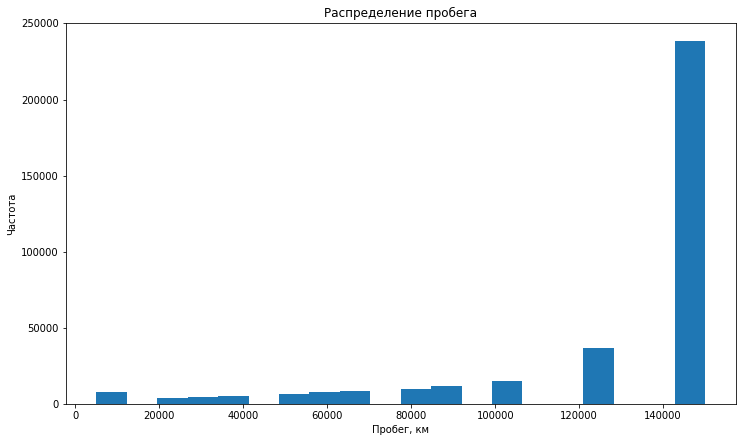

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [20]:
plt.figure(figsize=(12, 7))
plt.hist(df['Kilometer'], bins=20)
plt.title('Распределение пробега')
plt.xlabel('Пробег, км')
plt.ylabel('Частота')
plt.show()
df['Kilometer'].describe()

In [21]:
df['FuelType'].value_counts(normalize=True)

petrol      0.672999
gasoline    0.307086
lpg         0.016518
cng         0.001758
hybrid      0.000725
other       0.000635
electric    0.000280
Name: FuelType, dtype: float64

In [22]:
df['Brand'].value_counts(normalize=True)

volkswagen        0.217324
opel              0.112683
bmw               0.104169
mercedes_benz     0.090427
audi              0.083123
ford              0.071054
renault           0.050589
peugeot           0.031036
fiat              0.027212
seat              0.019491
mazda             0.015845
skoda             0.015521
smart             0.014804
citroen           0.014527
nissan            0.013943
toyota            0.012998
hyundai           0.010122
sonstige_autos    0.009521
volvo             0.009058
mini              0.009036
mitsubishi        0.008528
honda             0.007949
kia               0.006956
suzuki            0.006553
alfa_romeo        0.006530
chevrolet         0.004950
chrysler          0.004061
dacia             0.002540
daihatsu          0.002274
subaru            0.002150
porsche           0.002139
jeep              0.001910
trabant           0.001662
land_rover        0.001538
daewoo            0.001529
saab              0.001484
jaguar            0.001425
r

In [23]:
df['NotRepaired'].value_counts(normalize=True)

no     0.872699
yes    0.127301
Name: NotRepaired, dtype: float64

In [24]:
df['NumberOfPictures'].value_counts(normalize=True)

0    1.0
Name: NumberOfPictures, dtype: float64

In [25]:
df_clear.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.059373
RegistrationYear     0.000000
Gearbox              0.046272
Power                0.000000
Model                0.046719
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.072192
Brand                0.000000
NotRepaired          0.180242
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

**Заполняем пропуски**

Удаление пропусков нецелесообразно, т.к. их много (не менее 15.7 %). Возможное значение в пропусках предугадать невозможно. Поэтому заполняем пропуски значением 'unknown'.

In [26]:
df_clear['NotRepaired'] = df_clear['NotRepaired'].fillna('unknown')
df_clear['VehicleType'] = df_clear['VehicleType'].fillna('unknown')
df_clear['Gearbox'] = df_clear['Gearbox'].fillna('unknown')
df_clear['Model'] = df_clear['Model'].fillna('unknown')
df_clear['FuelType'] = df_clear['FuelType'].fillna('unknown')

In [27]:
df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328514 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        328514 non-null  object 
 1   Price              328514 non-null  int64  
 2   VehicleType        328514 non-null  object 
 3   RegistrationYear   328514 non-null  int64  
 4   Gearbox            328514 non-null  object 
 5   Power              328514 non-null  float64
 6   Model              328514 non-null  object 
 7   Kilometer          328514 non-null  int64  
 8   RegistrationMonth  328514 non-null  int64  
 9   FuelType           328514 non-null  object 
 10  Brand              328514 non-null  object 
 11  NotRepaired        328514 non-null  object 
 12  DateCreated        328514 non-null  object 
 13  NumberOfPictures   328514 non-null  int64  
 14  PostalCode         328514 non-null  int64  
 15  LastSeen           328514 non-null  object 
dtypes:

In [28]:
display(df_clear)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,101.0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190.0,unknown,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354359,2016-03-27 20:36:20,1150,bus,2000,manual,125.0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354361,2016-03-14 17:48:27,2200,unknown,2005,unknown,110.0,unknown,20000,1,unknown,sonstige_autos,unknown,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354362,2016-03-05 19:56:21,1199,convertible,2000,auto,101.0,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354363,2016-03-19 18:57:12,9200,bus,1996,manual,102.0,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [29]:
#переводим даты в правильный формат
df_clear['DateCrawled'] = pd.to_datetime(df_clear['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
df_clear['DateCreated'] = pd.to_datetime(df_clear['DateCreated'], format='%Y-%m-%d %H:%M:%S')
df_clear['LastSeen'] = pd.to_datetime(df_clear['LastSeen'], format='%Y-%m-%d %H:%M:%S')

In [30]:
df_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328514 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        328514 non-null  datetime64[ns]
 1   Price              328514 non-null  int64         
 2   VehicleType        328514 non-null  object        
 3   RegistrationYear   328514 non-null  int64         
 4   Gearbox            328514 non-null  object        
 5   Power              328514 non-null  float64       
 6   Model              328514 non-null  object        
 7   Kilometer          328514 non-null  int64         
 8   RegistrationMonth  328514 non-null  int64         
 9   FuelType           328514 non-null  object        
 10  Brand              328514 non-null  object        
 11  NotRepaired        328514 non-null  object        
 12  DateCreated        328514 non-null  datetime64[ns]
 13  NumberOfPictures   328514 non-null  int64   

**Подготавливаем данные к обучению моделей**

Столбцы 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen' не влияют на стоимость авто, но могут запутать модель. Удаляем их.

In [31]:
#удаляем ненужные столбцы
data = df_clear.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [32]:
display(data)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.0,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354359,1150,bus,2000,manual,125.0,zafira,150000,petrol,opel,no
354361,2200,unknown,2005,unknown,110.0,unknown,20000,unknown,sonstige_autos,unknown
354362,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
354363,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


Чтобы увеличить качество простых моделей (линейной регрессии, дерева решений и случайного леса) применяем технику One-Hot Encoding и масштабирование признаков.

In [33]:
#кодируем категориальные признаки с помощью One-Hot Encoding
data_dummies = pd.get_dummies(data, drop_first=True)
data_dummies.info()
display(data_dummies)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328514 entries, 0 to 354364
Columns: 312 entries, Price to NotRepaired_yes
dtypes: float64(1), int64(3), uint8(308)
memory usage: 109.0 MB


,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993,101.0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190.0,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75.0,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69.0,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354359,1150,2000,125.0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354361,2200,2005,110.0,20000,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
354362,1199,2000,101.0,125000,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
354363,9200,1996,102.0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [34]:
#создаем выборки с признаками и целевым признаком
features_ohe = data_dummies.drop(['Price'], axis=1)
target_ohe = data_dummies['Price']

#разделяем выборки на обучающую и тестовую
features_train_ohe, features_test_ohe, target_train, target_test = train_test_split(features_ohe, 
                                                                                            target_ohe, 
                                                                                            test_size=0.25,
                                                                                            random_state=12345)


print(features_train_ohe.shape)
print(target_train.shape)
print(features_test_ohe.shape)
print(target_test.shape)

(246385, 311)
(246385,)
(82129, 311)
(82129,)


In [35]:
#масштабируем численные признаки
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

/tmp/ipykernel_541/4031354681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_541/4031354681.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Для моделей с деревьями целесообразно кодировать категориальные признаки с помощью OrdinalEncoder. Создаем выборки с данным методом кодирования.

In [36]:
encoder = OrdinalEncoder()
data_oe = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)
display(data_oe)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,253.0,7.0,42.0,1.0,92.0,116.0,12.0,6.0,38.0,1.0
1,3550.0,2.0,60.0,1.0,185.0,228.0,11.0,2.0,1.0,2.0
2,2558.0,6.0,53.0,0.0,158.0,117.0,11.0,2.0,14.0,1.0
3,689.0,5.0,50.0,1.0,66.0,116.0,12.0,6.0,38.0,0.0
4,1314.0,5.0,57.0,1.0,60.0,101.0,9.0,2.0,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...
328509,544.0,0.0,49.0,1.0,117.0,250.0,12.0,6.0,24.0,0.0
328510,910.0,7.0,54.0,2.0,101.0,228.0,2.0,7.0,33.0,1.0
328511,562.0,1.0,49.0,0.0,92.0,106.0,11.0,6.0,32.0,0.0
328512,2462.0,0.0,45.0,1.0,93.0,224.0,12.0,2.0,38.0,0.0


In [37]:
features_oe = data_oe.drop(['Price'], axis=1)
target_oe = data_oe['Price']

#разделяем выборку на обучающую и тестовую
features_train_oe, features_test_oe = train_test_split(features_oe, 
                                                       test_size=0.25,
                                                       random_state=12345)

print(features_train_oe.shape)
print(features_test_oe.shape)

(246385, 9)
(82129, 9)


## Обучение моделей

In [38]:
#создаем оценщик моделей

def rmse_function(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return abs(mse)**0.5

rmse = make_scorer(rmse_function, greater_is_better=False)

In [39]:
folds = StratifiedKFold(n_splits=5,  shuffle=True, random_state=12345)   

In [40]:
results = {'training_time': [],
           'pred_time': [],
           'cv_rmse': [],
           'test_rmse': []
          }

### Линейная регрессия

In [41]:
#обучаем модель
model_lr = LinearRegression()
cv_lr = cross_val_score(estimator=model_lr, 
                      X=features_train_ohe,
                      y=target_train, 
                      scoring=rmse,
                      cv=folds, 
                      n_jobs=-1)

print(abs(cv_lr.mean()))
#results.setdefault('cv_rmse',[]).append('{0:.2f}'.format(abs(res.mean())))

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


2645.3519404675867


In [58]:
#создаем функцию для автоматизации моделирования и записи результатов
def modelling(model, features_train, target_train, features_test, target_test, cv_res):
    start_train = time.time()
    model.fit(features_train, target_train)
    stop_train = time.time()
    pred_test = model.predict(features_test)
    stop_test = time.time()
    results.setdefault('training_time',[]).append('{0:.3f}'.format(stop_train-start_train))
    results.setdefault('pred_time',[]).append('{0:.3f}'.format(stop_test-stop_train))
    results.setdefault('test_rmse',[]).append('{0:.2f}'.format(rmse_function(target_test, pred_test)))
    results.setdefault('cv_rmse',[]).append('{0:.2f}'.format(abs(cv_res.mean())))
    display(results)

In [43]:
modelling(model_lr, features_train_ohe, target_train, features_test_ohe, target_test, cv_lr)

{'training_time': ['23.590'],
 'pred_time': ['0.139'],
 'cv_rmse': ['2645.35'],
 'test_rmse': ['2631.35']}

* RMSE модели линейной регрессии на кросс-валидации равен 2645.35, на тестовой 2631.35. Результаты практически сходятся, значит модель достаточно обучена и не переобучилась.
* Время обучения составило 18.4 с. Время предсказания 191 мс.

### Дерево решений

In [44]:
%%time

model_dt = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth': range(3,21,1)}
grid_dt = GridSearchCV(model_dt, param_grid=parameters, scoring=rmse, n_jobs=-1, cv=folds)
grid_dt.fit(features_train_oe, target_train)
cv_dt= grid_dt.best_score_
print(grid_dt.best_params_)
print(abs(grid_dt.best_score_))

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'max_depth': 14}
1928.286049056443
CPU times: user 37.7 s, sys: 62.2 ms, total: 37.8 s
Wall time: 37.9 s


In [45]:
modelling(grid_dt.best_estimator_, features_train_oe, target_train, features_test_oe, target_test, cv_dt)

{'training_time': ['23.590', '0.655'],
 'pred_time': ['0.139', '0.015'],
 'cv_rmse': ['2645.35', '1928.29'],
 'test_rmse': ['2631.35', '1889.56']}

* Для дерева решений наиболее подходящая глубина 14.

* Время обучения модели составило 0.6 с., время предсказания 14 мс.

* RMSE на кросс-валидации составило 1928.29, на тестовой 1889.56.

### Случайный лес

In [46]:
%%time

model_rf = RandomForestRegressor(random_state=12345)
parameters = {'max_depth': range(3,16,1), 'n_estimators' : [10, 20, 40, 60, 100, 200, 300, 500]}
grid_rf = GridSearchCV(model_rf, param_grid=parameters, scoring=rmse, n_jobs=-1, cv=folds)
grid_rf.fit(features_train_oe, target_train)
cv_rf= grid_rf.best_score_
print(grid_rf.best_params_)
print(abs(grid_rf.best_score_))

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'max_depth': 15, 'n_estimators': 500}
1664.4110266199677
CPU times: user 2h 54min 2s, sys: 28.6 s, total: 2h 54min 31s
Wall time: 2h 54min 34s


In [47]:
modelling(grid_rf.best_estimator_, features_train_oe, target_train, features_test_oe, target_test, cv_rf)

{'training_time': ['23.590', '0.655', '260.594'],
 'pred_time': ['0.139', '0.015', '7.322'],
 'cv_rmse': ['2645.35', '1928.29', '1664.41'],
 'test_rmse': ['2631.35', '1889.56', '1635.21']}

* Оптимальные гиперпараметры для случайного леса: глубина 15, число деревьев 500.

* Время обучения модели составило 242 с. (4 мин. 2 с.), время предсказания 7.8 с.

* RMSE на кросс-валидации составил 1644.36, на тестовой выборке 1612.75. Модель не переобучена.

Лучшие значения RMSE получили на максимальных гиперпараметрах из исследованных. Вероятно, качество модели можно еще повысить за счет увеличения количества деревьев и глубины. Однако имеющаяся модель уже медленно обучается и предсказывает, и за счет увеличения деревьев и глубины скорость снизится еще сильнее. Это не соответствует требованиям заказчика, поэтому дальнейшее увеличение гиперпараметров нецелесообразно.

### Модель градиентного бустинга

Для моделей градиентного бустинга применять кодирование и масштабирование признаков нецелесообразно. Поэтому создаем новую выборку с признаками. Также для корректной работы моделей нужно перевести в категориальные признаки в формат категорий.

In [48]:
features = data.drop(['Price'], axis=1)
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
features[cat_columns] = features[cat_columns].astype('category')
target = data['Price']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=12345)

**CatBoost**

In [49]:
%%time

model_cbr = CatBoostRegressor(cat_features = cat_columns, thread_count=-1)
parameters = {'learning_rate': [0.1, 0.2, 0.3],
              'depth': [3, 6, 10, 15],
              'iterations': [100, 200, 300, 500]
             }
grid_cbr = GridSearchCV(model_cbr, param_grid=parameters, cv=folds, scoring=rmse)

grid_cbr.fit(features_train, target_train)
cv_cbr = grid_cbr.best_score_

print(grid_cbr.best_params_)
print(grid_cbr.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'depth': 15, 'iterations': 500, 'learning_rate': 0.1}
-1569.6211573563899
CPU times: user 11h 33min, sys: 32min 20s, total: 12h 5min 20s
Wall time: 12h 8min 31s


In [50]:
modelling(grid_cbr.best_estimator_, features_train, target_train, features_test, target_test, cv_cbr)

{'training_time': ['23.590', '0.655', '260.594', '1061.043'],
 'pred_time': ['0.139', '0.015', '7.322', '1.558'],
 'cv_rmse': ['2645.35', '1928.29', '1664.41', '1569.62'],
 'test_rmse': ['2631.35', '1889.56', '1635.21', '1554.53']}

* Оптимальные гиперпараметры (среди исследованных) для CatBoostRegressor: learning_rate=0.1, depth=15, iterations=500.

* Время обучения составило 1061 с. , предсказания - 1.6 с. 

* RMSE предсказаний на кросс-валидации составил 1569.62, на тестовой выборке 1554.53. Признаков переобучения нет.

**LightGBM**

In [51]:
%%time

model_lgbm = LGBMRegressor(n_jobs=-1, random_state=12345)
parameters = {'learning_rate': [0.1, 0.2, 0.3],
              'max_depth': [3, 6, 10, 15],
              'n_estimators': [100, 200, 300, 500]
             }
grid_lgbm = GridSearchCV(model_lgbm, param_grid=parameters, cv=folds, scoring=rmse)

grid_lgbm.fit(features_train, target_train)
cv_lgbm = grid_lgbm.best_score_

print(grid_lgbm.best_params_)
print(grid_lgbm.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 500}
-1564.8965688984892
CPU times: user 2h 3min 22s, sys: 51.8 s, total: 2h 4min 14s
Wall time: 2h 4min 59s


In [52]:
modelling(grid_lgbm.best_estimator_, features_train, target_train, features_test, target_test, cv_lgbm)

{'training_time': ['23.590', '0.655', '260.594', '1061.043', '15.904'],
 'pred_time': ['0.139', '0.015', '7.322', '1.558', '3.029'],
 'cv_rmse': ['2645.35', '1928.29', '1664.41', '1569.62', '1564.90'],
 'test_rmse': ['2631.35', '1889.56', '1635.21', '1554.53', '1554.78']}

* Оптимальные гиперпараметры: learning_rate=0.2, max_depth=15, n_estimators=500.

* Время обучения модели составило 15.9 с., предсказания 3 с.

* RMSE предсказаний на кросс-валидации составил 1564.90, на тестовой выборке 1554.78.

## Анализ моделей

In [57]:
#строим таблицу с результатами
columns = pd.Series(['Linear_Regression', 'Decision_Tree', 'Random_Forest', 'Cat_Boost_Regressor', 'LGBM_Regressor'])
table = pd.DataFrame.from_dict(results, orient='index', columns=columns)
display(table)

,Linear_Regression,Decision_Tree,Random_Forest,Cat_Boost_Regressor,LGBM_Regressor
training_time,23.590,0.655,260.594,1061.043,15.904
pred_time,0.139,0.015,7.322,1.558,3.029
cv_rmse,2645.35,1928.29,1664.41,1569.62,1564.90
test_rmse,2631.35,1889.56,1635.21,1554.53,1554.78


* Простые модели (линейная регрессия, решающее дерево) имеют высокую скорость обучения и предсказания, но качество результатов намного ниже, чем у моделей градиентного бустинга.

* Модель случайного леса долго обучается относительно простых моделей и LGBM. Скорость предсказаний у нее самая низкая из всех исследованных моделей. Качество результатов выше, чем у простых моделей, но ниже, чем у моделей градиентного бустинга.

* Обе модели градиентного бустинга показали схожую точность результатов. Однако Cat_Boost_Regressor дольше всех обучалась (в 4 раза дольше, чем случайный лес). Скорость предсказаний у Cat_Boost_Regressor в десятки раз ниже, чем у простых моделей, но примерно в 5 раз выше, чем у случайного леса и в 2 раза выше, чем у LGBM.

* Модель LGBM_Regressor	имеет одну из самых высоких скоростей обучения (выше, чем у линейной регрессии), но скорость предсказаний одна из самых низких. Точность предсказаний у LGBM самая высокая из всех исследованных моделей.

**Исходя из требований заказчика, оптимальной будет модель LGBM_Regressor. Она обеспечивает оптимальное соотношение точности и скорости предсказаний, а также времени обучения.**